# Step 3: Sentiment Analysis, Topic Modeling, and Network analysis

### 3.1 Imporing Necessary Libraries and Setup

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re # For text cleaning
import os # For path management and directory creation
import joblib # For saving/loading sklearn models/objects
import networkx as nx # For graph creation, analysis, and saving
from collections import Counter # For co-occurrence counts
import itertools # For combinations

# For Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from textblob import TextBlob # User had it, but we focused on VADER

# For TF-IDF and Topic Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation #, NMF # User had NMF, we focused on LDA

# Configure Settings
import warnings
warnings.filterwarnings('ignore') # Use with caution, good for final notebook presentation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 80) # Adjust as needed
pd.set_option('display.float_format', lambda x: '%.3f' % x) # Format floats for pandas
sns.set_style('whitegrid') # Sets a nice style for seaborn plots

# Download VADER lexicon if necessary (run once in your environment)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    print("Downloading VADER lexicon...")
    nltk.download('vader_lexicon')
else:
    print("VADER lexicon found.")

print("Libraries imported and base settings configured.")

# Define project directories
# Assuming this notebook is in a 'notebooks' folder,
# and 'data' & 'artifacts' are sibling folders to 'notebooks' at the project root.
# If your notebook is in the project root, adjust paths like: DATA_DIR = 'data/'
try:
    # This gets the directory where the notebook (or .py script) is located
    current_file_path = os.path.abspath("") # For Jupyter Notebooks specifically
    notebooks_dir = os.path.dirname(current_file_path) if os.path.basename(current_file_path).endswith('.ipynb') else current_file_path
    # If the notebook is in a 'notebooks' folder, go one level up for project root
    if os.path.basename(notebooks_dir) == 'notebooks':
        PROJECT_ROOT = os.path.dirname(notebooks_dir)
    else: # Assume notebook is in project root
        PROJECT_ROOT = notebooks_dir
except NameError: # If __file__ is not defined (e.g., interactive session not in a file)
    PROJECT_ROOT = os.getcwd() # Fallback to current working directory
    print("Warning: Could not reliably determine project root. Using current working directory.")


DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
ARTIFACTS_DIR = os.path.join(PROJECT_ROOT, 'artifacts')

# Create the artifacts directory if it doesn't exist
if not os.path.exists(ARTIFACTS_DIR):
    os.makedirs(ARTIFACTS_DIR)
    print(f"Created directory: {ARTIFACTS_DIR}")
else:
    print(f"Artifacts directory already exists: {ARTIFACTS_DIR}")

print(f"Data directory configured at: {DATA_DIR}")
print(f"Artifacts directory configured at: {ARTIFACTS_DIR}")

VADER lexicon found.
Libraries imported and base settings configured.
Artifacts directory already exists: /Users/ramesh/Desktop/Automated Insight Extraction/artifacts
Data directory configured at: /Users/ramesh/Desktop/Automated Insight Extraction/data
Artifacts directory configured at: /Users/ramesh/Desktop/Automated Insight Extraction/artifacts


### 3.2. Load Processed Data (from Notebook 02)

In [8]:
PROCESSED_DATA_FILE_STEP2 = os.path.join(DATA_DIR, 'reviews_nlp_processed_step2.csv') # From Notebook 02

def load_data_from_step2(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Processed data loaded successfully from {file_path}. Shape: {df.shape}")
        # Ensure key text columns are strings and handle potential NaNs from CSV read/write
        if 'processed_text_joined' in df.columns:
            df['processed_text_joined'] = df['processed_text_joined'].astype(str).fillna('')
        if 'Review Text' in df.columns:
            df['Review Text'] = df['Review Text'].astype(str).fillna('')
        # Handle list-like columns if they were saved as strings
        list_like_cols = ['processed_tokens', 'active_lda_topics_above_threshold'] # Add 'active_lda_topics_above_threshold' if it exists from a previous run and was saved
        for col in list_like_cols:
            if col in df.columns and isinstance(df[col].iloc[0], str):
                try:
                    # Safely evaluate string representations of lists
                    df[col] = df[col].apply(lambda x: eval(x) if pd.notnull(x) and isinstance(x, str) and x.startswith('[') and x.endswith(']') else x)
                    print(f"Column '{col}' converted from string to list.")
                except Exception as e_eval:
                    print(f"Could not evaluate column '{col}' as list: {e_eval}. Leaving as string.")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please ensure 'reviews_nlp_processed_step2.csv' exists in '{DATA_DIR}'.")
        return None
    except Exception as e:
        print(f"An error occurred loading data: {e}")
        return None

df_processed = load_data_from_step2(PROCESSED_DATA_FILE_STEP2)

if df_processed is not None:
    print("\n--- First 5 Rows of Loaded df_processed ---")
    print(df_processed.head())
    df_processed.info()
    # Define TEXT_COLUMN_TO_PROCESS for display purposes later
    TEXT_COLUMN_TO_PROCESS = 'Review Text' # This is the original, human-readable review
    print(f"\nUsing '{TEXT_COLUMN_TO_PROCESS}' for displaying original review text context.")
else:
    print("Data loading failed. Cannot proceed with further analysis in this notebook.")

Processed data loaded successfully from /Users/ramesh/Desktop/Automated Insight Extraction/data/reviews_nlp_processed_step2.csv. Shape: (23465, 14)
Column 'processed_tokens' converted from string to list.

--- First 5 Rows of Loaded df_processed ---
   Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                                                       Review Text  \
0                            Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i...   
2  I had such high hopes for this dress and really wanted it to work for me. i ...   
3  I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time...   
4  This shirt is very flatterin

### 3.3. Sentiment Analysis


--- Starting Sentiment Analysis ---
VADER sentiment analysis complete.

--- First 5 Rows with Sentiment Scores and Labels ---
                                                                       Review Text  \
0                            Absolutely wonderful - silky and sexy and comfortable   
1  Love this dress!  it's sooo pretty.  i happened to find it in a store, and i...   
2  I had such high hopes for this dress and really wanted it to work for me. i ...   
3  I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time...   
4  This shirt is very flattering to all due to the adjustable front tie. it is ...   

                                                             processed_text_joined  \
0                                      absolutely wonderful silky sexy comfortable   
1  love dress sooo pretty happen find store glad bc order online bc petite buy ...   
2  high hope dress want work initially order petite small usual size find outra...   
3           

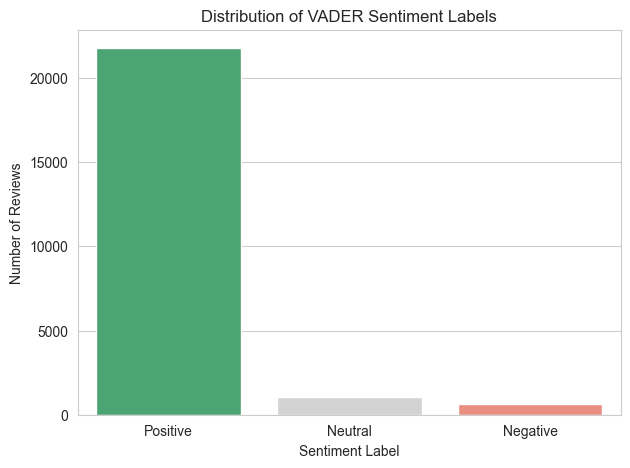

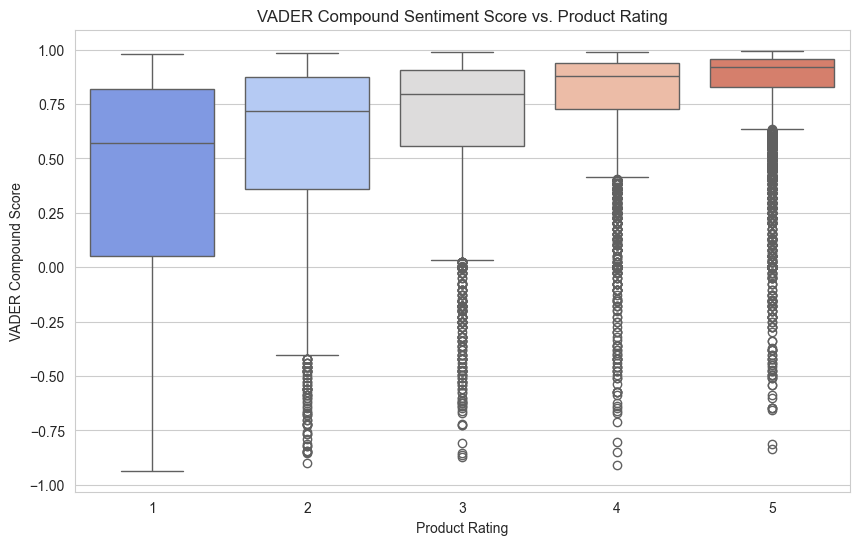


--- Crosstab: VADER Sentiment vs. Product Rating (Percentages) ---
vader_sentiment_label  Negative  Neutral  Positive
Rating                                            
1                        18.800    6.100    75.200
2                         9.900    4.200    85.900
3                         5.000    4.100    90.900
4                         1.500    4.300    94.200
5                         0.600    4.800    94.600


In [9]:
if df_processed is not None:
    print("\n--- Starting Sentiment Analysis ---")
    analyzer = SentimentIntensityAnalyzer()

    def get_vader_sentiment(text):
        if not isinstance(text, str) or not text.strip():
            return {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} # Default for empty text
        return analyzer.polarity_scores(text)

    # Apply VADER to 'processed_text_joined' as it's cleaned
    sentiment_scores = df_processed['processed_text_joined'].apply(get_vader_sentiment)
    df_sentiment = pd.json_normalize(sentiment_scores)
    
    # Ensure indices align before concatenation if df_processed was modified (e.g., dropping NaNs not done here but in NB2)
    df_processed = pd.concat([df_processed.reset_index(drop=True), df_sentiment.reset_index(drop=True)], axis=1)

    def classify_sentiment(compound_score):
        if compound_score >= 0.05:
            return 'Positive'
        elif compound_score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
            
    df_processed['vader_sentiment_label'] = df_processed['compound'].apply(classify_sentiment)
    print("VADER sentiment analysis complete.")
    print("\n--- First 5 Rows with Sentiment Scores and Labels ---")
    print(df_processed[[TEXT_COLUMN_TO_PROCESS, 'processed_text_joined', 'compound', 'vader_sentiment_label']].head())

    print("\n--- Sentiment Label Distribution (VADER) ---")
    sentiment_distribution = df_processed['vader_sentiment_label'].value_counts(normalize=True) * 100
    print(sentiment_distribution)

    plt.figure(figsize=(7, 5))
    sns.countplot(x='vader_sentiment_label', data=df_processed, palette={'Positive':'mediumseagreen', 'Neutral':'lightgray', 'Negative':'salmon'}, order=['Positive', 'Neutral', 'Negative'])
    plt.title('Distribution of VADER Sentiment Labels')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Number of Reviews')
    plt.show()

    if 'Rating' in df_processed.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Rating', y='compound', data=df_processed, palette='coolwarm')
        plt.title('VADER Compound Sentiment Score vs. Product Rating')
        plt.xlabel('Product Rating')
        plt.ylabel('VADER Compound Score')
        plt.show()
        
        print("\n--- Crosstab: VADER Sentiment vs. Product Rating (Percentages) ---")
        print(pd.crosstab(df_processed['Rating'], df_processed['vader_sentiment_label'], normalize='index').mul(100).round(1))
else:
    print("df_processed not available for Sentiment Analysis.")


### 3.4. Feature Extraction for Topic Modeling (TF-IDF)


In [10]:
if df_processed is not None and 'processed_text_joined' in df_processed.columns:
    print("\n--- Starting TF-IDF Feature Extraction ---")
    corpus = df_processed['processed_text_joined'].fillna('')

    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90,     # Ignore words appearing in > 90% of documents
        min_df=5,        # Word must appear in at least 5 documents
        # max_features=5000, # Optional: Limit vocabulary size
        ngram_range=(1,1)  # Consider only unigrams
    )
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    print(f"TF-IDF matrix created successfully. Shape: {tfidf_matrix.shape}")
    print(f"Number of features (vocabulary size): {len(feature_names)}")
    print(f"First 10 feature names: {feature_names[:10]}")

    # --- SAVING TF-IDF Vectorizer and Feature Names ---
    try:
        tfidf_vectorizer_path = os.path.join(ARTIFACTS_DIR, 'tfidf_vectorizer.joblib')
        joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
        print(f"TF-IDF Vectorizer saved to: {tfidf_vectorizer_path}")

        feature_names_path = os.path.join(ARTIFACTS_DIR, 'tfidf_feature_names.joblib')
        joblib.dump(feature_names, feature_names_path)
        print(f"TF-IDF Feature Names saved to: {feature_names_path}")
    except Exception as e:
        print(f"Error saving TF-IDF components: {e}")
else:
    print("df_processed or 'processed_text_joined' not available for TF-IDF.")


--- Starting TF-IDF Feature Extraction ---
TF-IDF matrix created successfully. Shape: (23465, 3665)
Number of features (vocabulary size): 3665
First 10 feature names: ['aa' 'ab' 'abdomen' 'ability' 'able' 'absolute' 'absolutely' 'abstract'
 'abt' 'abundance']
TF-IDF Vectorizer saved to: /Users/ramesh/Desktop/Automated Insight Extraction/artifacts/tfidf_vectorizer.joblib
TF-IDF Feature Names saved to: /Users/ramesh/Desktop/Automated Insight Extraction/artifacts/tfidf_feature_names.joblib


### 3.5. Topic Modeling with LDA


--- Starting Topic Modeling with LDA ---
Number of topics chosen: 7
Fitting LDA model with 7 topics...
LDA model fitting complete.
Shape of LDA components (word-topic distribution): (7, 3665)
LDA Model saved to: /Users/ramesh/Desktop/Automated Insight Extraction/artifacts/lda_model.joblib

--- Top 10 words per topic ---
Topic 1: size, dress, small, order, fit, try, look, like, love, large
Topic 2: dress, fit, size, look, waist, skirt, love, like, wear, flattering
Topic 3: dress, wear, love, great, color, look, beautiful, comfortable, like, fit
Topic 4: size, fit, love, small, wear, great, color, medium, run, large
Topic 5: love, great, wear, jean, color, fit, comfortable, dress, look, soft
Topic 6: nan, measurement, omg, impress, darker, frequently, bland, instant, faded, blocking
Topic 7: look, like, shirt, fabric, love, fit, size, sweater, sleeve, material

--- First 5 Reviews with Dominant LDA Topic ---
                                                                       Review T

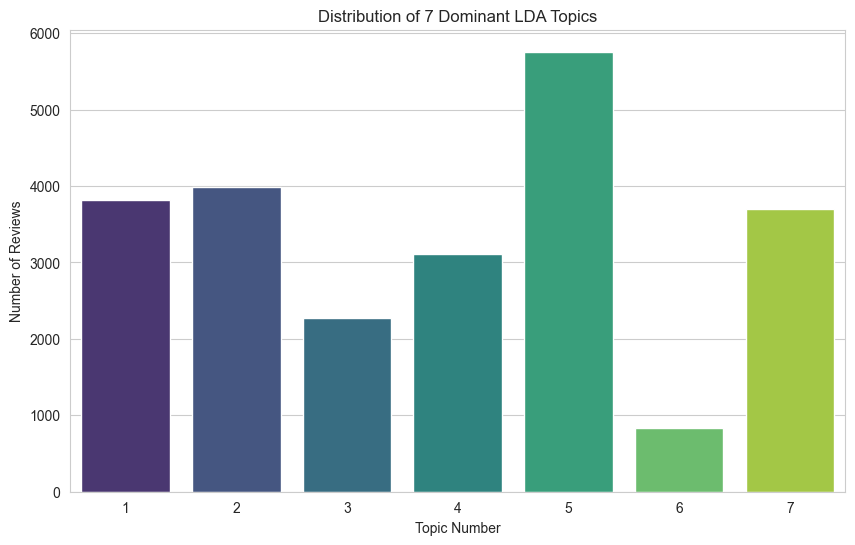

In [11]:
if 'tfidf_matrix' in locals() and 'feature_names' in locals() and df_processed is not None:
    print("\n--- Starting Topic Modeling with LDA ---")
    NUM_TOPICS = 7 # Define your chosen number of topics
    print(f"Number of topics chosen: {NUM_TOPICS}")

    lda_model = LatentDirichletAllocation(
        n_components=NUM_TOPICS,
        learning_method='batch',
        random_state=42, # For reproducibility
        n_jobs=-1,       # Use all available CPUs
        max_iter=10      # Default is 10, can increase if convergence issues
    )
    print(f"Fitting LDA model with {NUM_TOPICS} topics...")
    lda_topic_matrix = lda_model.fit_transform(tfidf_matrix)
    print("LDA model fitting complete.")
    print(f"Shape of LDA components (word-topic distribution): {lda_model.components_.shape}")

    # --- SAVING LDA Model ---
    try:
        lda_model_path = os.path.join(ARTIFACTS_DIR, 'lda_model.joblib')
        joblib.dump(lda_model, lda_model_path)
        print(f"LDA Model saved to: {lda_model_path}")
    except Exception as e:
        print(f"Error saving LDA model: {e}")

    def display_topics(model, features, num_top_words=10):
        print(f"\n--- Top {num_top_words} words per topic ---")
        for topic_idx, topic_weights in enumerate(model.components_):
            top_word_indices = topic_weights.argsort()[:-num_top_words - 1:-1]
            top_words = [features[i] for i in top_word_indices]
            print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    display_topics(lda_model, feature_names, 10)

    df_processed['dominant_lda_topic'] = lda_topic_matrix.argmax(axis=1) + 1 # +1 for 1-indexed topics
    print("\n--- First 5 Reviews with Dominant LDA Topic ---")
    # Ensure TEXT_COLUMN_TO_PROCESS is defined
    if TEXT_COLUMN_TO_PROCESS in df_processed.columns:
        print(df_processed[[TEXT_COLUMN_TO_PROCESS, 'dominant_lda_topic', 'Rating', 'vader_sentiment_label']].head())
    else:
        print(df_processed[['processed_text_joined', 'dominant_lda_topic', 'Rating', 'vader_sentiment_label']].head())


    print("\n--- Distribution of Dominant Topics Across Reviews ---")
    topic_counts = df_processed['dominant_lda_topic'].value_counts().sort_index()
    print(topic_counts)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
    plt.title(f'Distribution of {NUM_TOPICS} Dominant LDA Topics')
    plt.xlabel('Topic Number')
    plt.ylabel('Number of Reviews')
    plt.xticks(ticks=range(NUM_TOPICS), labels=range(1, NUM_TOPICS + 1))
    plt.show()
else:
    print("TF-IDF matrix ('tfidf_matrix') or feature names ('feature_names') or df_processed not available. Skipping LDA.")

### 3.6. Analyze Topics with Sentiment & Ratings


--- Analyzing Sentiment per Dominant Topic ---
Average VADER Compound Sentiment Score per Dominant Topic:
dominant_lda_topic
1   0.704
2   0.817
3   0.815
4   0.839
5   0.850
6   0.000
7   0.690
Name: compound, dtype: float64


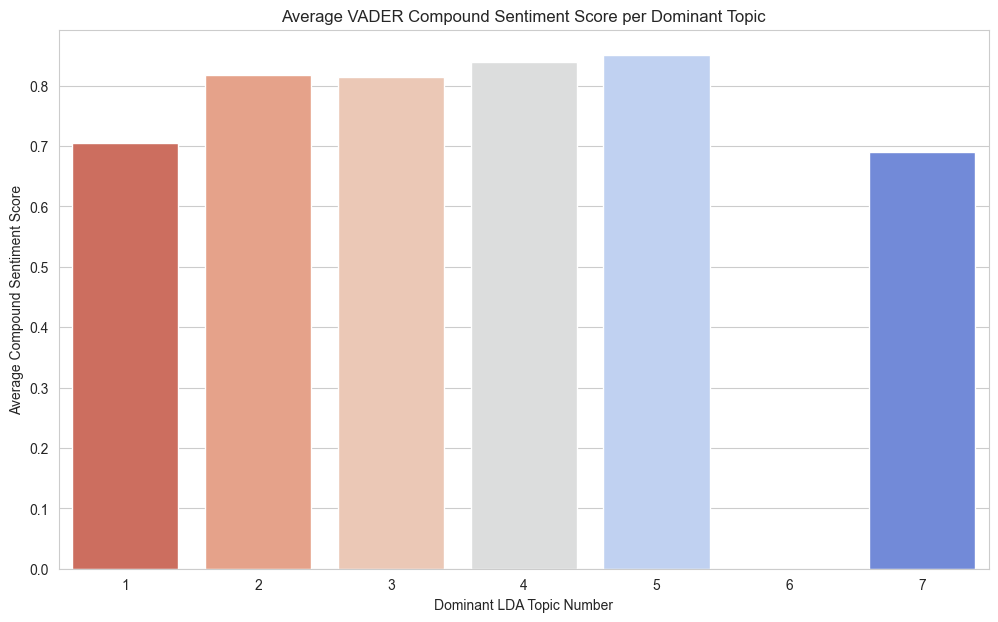


--- Analyzing Average Rating per Dominant Topic ---
Average Product Rating per Dominant Topic:
dominant_lda_topic
1   3.633
2   4.203
3   4.508
4   4.498
5   4.660
6   4.517
7   3.526
Name: Rating, dtype: float64


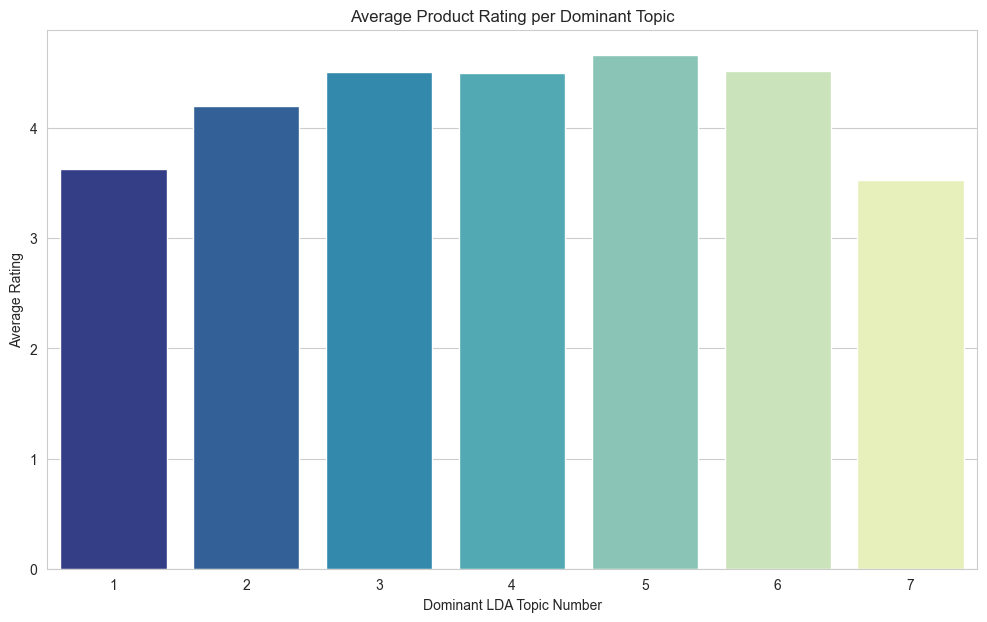

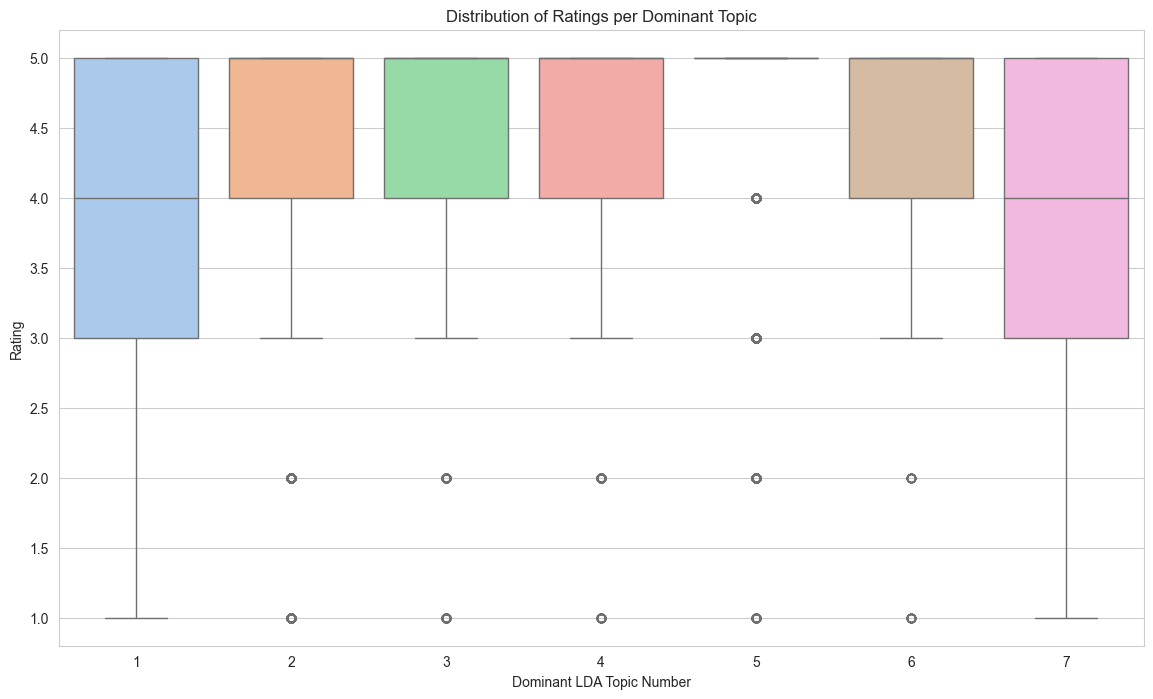


--- Sentiment Label Distribution per Dominant Topic (Percentages) ---
vader_sentiment_label  Negative  Neutral  Positive
dominant_lda_topic                                
1                         5.630    1.676    92.694
2                         1.856    1.078    97.066
3                         2.027    0.705    97.268
4                         0.837    0.869    98.295
5                         0.886    0.521    98.593
6                         0.000  100.000     0.000
7                         5.467    1.813    92.720


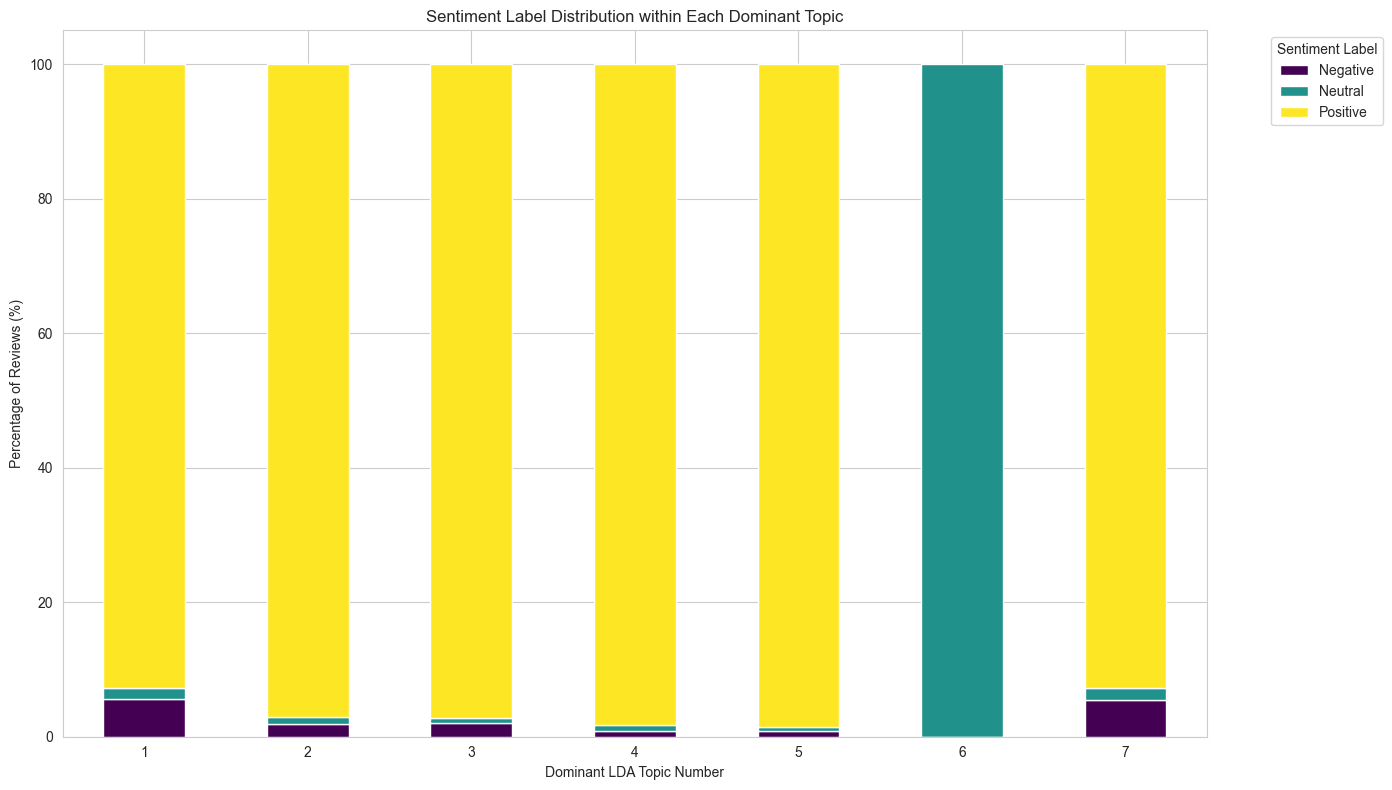

In [12]:
if df_processed is not None and 'dominant_lda_topic' in df_processed.columns and 'compound' in df_processed.columns:
    print("\n--- Analyzing Sentiment per Dominant Topic ---")
    sentiment_per_topic = df_processed.groupby('dominant_lda_topic')['compound'].mean().sort_index() # Sort by topic index
    print("Average VADER Compound Sentiment Score per Dominant Topic:")
    print(sentiment_per_topic)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=sentiment_per_topic.index, y=sentiment_per_topic.values, palette='coolwarm_r', order=sentiment_per_topic.index)
    plt.title('Average VADER Compound Sentiment Score per Dominant Topic')
    plt.xlabel('Dominant LDA Topic Number')
    plt.ylabel('Average Compound Sentiment Score')
    plt.show()

    if 'Rating' in df_processed.columns:
        print("\n--- Analyzing Average Rating per Dominant Topic ---")
        rating_per_topic = df_processed.groupby('dominant_lda_topic')['Rating'].mean().sort_index() # Sort by topic index
        print("Average Product Rating per Dominant Topic:")
        print(rating_per_topic)

        plt.figure(figsize=(12, 7))
        sns.barplot(x=rating_per_topic.index, y=rating_per_topic.values, palette='YlGnBu_r', order=rating_per_topic.index)
        plt.title('Average Product Rating per Dominant Topic')
        plt.xlabel('Dominant LDA Topic Number')
        plt.ylabel('Average Rating')
        plt.show()

        plt.figure(figsize=(14, 8))
        sns.boxplot(x='dominant_lda_topic', y='Rating', data=df_processed, palette='pastel', order=sorted(df_processed['dominant_lda_topic'].unique()))
        plt.title('Distribution of Ratings per Dominant Topic')
        plt.xlabel('Dominant LDA Topic Number')
        plt.ylabel('Rating')
        plt.show()

    if 'vader_sentiment_label' in df_processed.columns:
        print("\n--- Sentiment Label Distribution per Dominant Topic (Percentages) ---")
        topic_sentiment_distribution = df_processed.groupby('dominant_lda_topic')['vader_sentiment_label'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
        print(topic_sentiment_distribution)

        topic_sentiment_distribution.plot(
            kind='bar',
            stacked=True,
            figsize=(14, 8),
            colormap='viridis',
            title='Sentiment Label Distribution within Each Dominant Topic'
        )
        plt.ylabel('Percentage of Reviews (%)')
        plt.xlabel('Dominant LDA Topic Number')
        plt.xticks(rotation=0)
        plt.legend(title='Sentiment Label', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
else:
    print("Required columns for topic-sentiment/rating analysis are not available in df_processed.")


### 3.7. Topic Co-occurrence Network Analysis



--- Starting Topic Co-occurrence Network Analysis ---
Using probability threshold for topic presence: 0.2

Found 21 unique co-occurring topic pairs.

--- Top 10 Most Frequent Co-occurring Topic Pairs ---
Topics (2, 5): 562 times
Topics (1, 5): 527 times
Topics (5, 7): 502 times
Topics (2, 7): 402 times
Topics (1, 7): 362 times
Topics (3, 7): 360 times
Topics (1, 2): 350 times
Topics (2, 3): 344 times
Topics (1, 3): 323 times
Topics (4, 5): 321 times

Network Graph Created: 7 nodes, 21 edges.


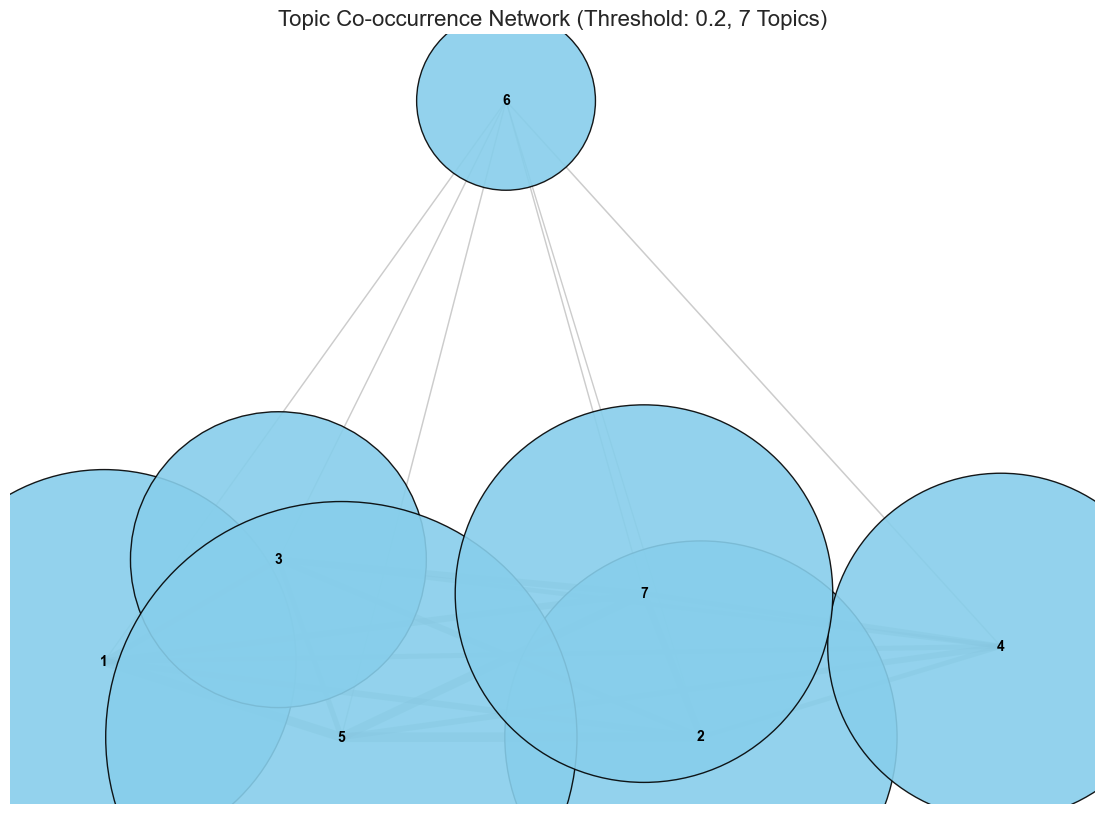


--- Degree Centrality (Top Topics by Number of Connections) ---
Topic 1: 1.000
Topic 2: 1.000
Topic 3: 1.000
Topic 4: 1.000
Topic 5: 1.000
NetworkX Graph saved to: /Users/ramesh/Desktop/Automated Insight Extraction/artifacts/topic_network.gexf


In [13]:
if 'lda_topic_matrix' in locals() and df_processed is not None and 'dominant_lda_topic' in df_processed.columns: # Ensure NUM_TOPICS defined for G node creation
    print("\n--- Starting Topic Co-occurrence Network Analysis ---")
    PROBABILITY_THRESHOLD = 0.20 # Tune this threshold
    print(f"Using probability threshold for topic presence: {PROBABILITY_THRESHOLD}")

    cooccurrence_counts = Counter()
    document_topic_assignments_thresholded = [] # Store list of active topics per doc

    for i in range(lda_topic_matrix.shape[0]):
        active_topics_in_doc = [topic_idx + 1 for topic_idx, prob in enumerate(lda_topic_matrix[i]) if prob >= PROBABILITY_THRESHOLD]
        document_topic_assignments_thresholded.append(active_topics_in_doc)
        if len(active_topics_in_doc) > 1:
            for pair in itertools.combinations(sorted(active_topics_in_doc), 2):
                cooccurrence_counts[pair] += 1
    
    # Add the list of active topics per document to the DataFrame (optional, for inspection)
    # This column might contain lists, ensure CSV saving/loading handles it or convert to string.
    df_processed['active_lda_topics_above_threshold'] = document_topic_assignments_thresholded
    
    print(f"\nFound {len(cooccurrence_counts)} unique co-occurring topic pairs.")
    print("\n--- Top 10 Most Frequent Co-occurring Topic Pairs ---")
    for pair, count in cooccurrence_counts.most_common(10):
        print(f"Topics {pair}: {count} times")

    G = nx.Graph()
    # Add nodes with size attribute based on dominant topic prevalence
    topic_prevalence = df_processed['dominant_lda_topic'].value_counts().to_dict()
    for i in range(1, NUM_TOPICS + 1): # Assuming NUM_TOPICS is defined (e.g., 7)
        G.add_node(i, size=topic_prevalence.get(i, 1) * 20) # Multiplier for visual scaling, ensure no zero size

    # Add edges with weights
    for pair, count in cooccurrence_counts.items():
        if count > 0: # Or set a minimum co-occurrence threshold for an edge
            topic1, topic2 = pair
            G.add_edge(topic1, topic2, weight=count)

    print(f"\nNetwork Graph Created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

    if G.number_of_nodes() > 0:
        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G, k=0.75, iterations=50, seed=42) # k adjusts spacing
        
        node_sizes = [G.nodes[node]['size'] for node in G.nodes()]
        
        edge_weights_raw = [G.edges[edge]['weight'] for edge in G.edges()]
        if edge_weights_raw:
            min_w, max_w = min(edge_weights_raw), max(edge_weights_raw)
            # Normalize edge widths for better visualization
            if max_w > min_w:
                 edge_widths = [1 + 6 * (w - min_w) / (max_w - min_w) for w in edge_weights_raw]
            else: # All weights are same
                 edge_widths = [2 for _ in edge_weights_raw] # Default width
        else:
            edge_widths = []

        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9, edgecolors='black')
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.4, edge_color='grey')
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
        
        # Optional: Draw edge labels (weights) - can make graph cluttered
        # edge_labels = {(u,v): d['weight'] for u,v,d in G.edges(data=True)}
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

        plt.title(f'Topic Co-occurrence Network (Threshold: {PROBABILITY_THRESHOLD}, {NUM_TOPICS} Topics)', fontsize=16)
        plt.axis('off')
        plt.show()
        
        if G.number_of_nodes() > 1:
            degree_centrality = nx.degree_centrality(G)
            print("\n--- Degree Centrality (Top Topics by Number of Connections) ---")
            sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
            for node, centrality in sorted_degree_centrality[:min(5, G.number_of_nodes())]: # Show top 5 or less
                 print(f"Topic {node}: {centrality:.3f}")
    else:
        print("Graph has no nodes, skipping visualization and analysis.")
        
    # --- SAVING NetworkX Graph G ---
    try:
        network_graph_path = os.path.join(ARTIFACTS_DIR, 'topic_network.gexf')
        nx.write_gexf(G, network_graph_path)
        print(f"NetworkX Graph saved to: {network_graph_path}")
    except Exception as e:
        print(f"Error saving NetworkX graph: {e}")
else:
    print("LDA topic matrix or df_processed not available for Network Analysis.")

### 3.8. Saving Final Processed DataFrame (with all new columns)

In [14]:
if df_processed is not None:
    try:
        final_df_path = os.path.join(DATA_DIR, 'reviews_final_for_streamlit.csv')
        
        # Convert list-like columns to string representations for CSV compatibility if they haven't been already
        # This is important if you have columns like 'processed_tokens' or 'active_lda_topics_above_threshold' still as lists
        df_to_save = df_processed.copy()
        for col in ['processed_tokens', 'active_lda_topics_above_threshold']:
            if col in df_to_save.columns:
                 # Check if elements are lists and convert to string, handle other types gracefully
                 if not df_to_save[col].empty and isinstance(df_to_save[col].iloc[0], list):
                     df_to_save[col] = df_to_save[col].astype(str)
                 elif df_to_save[col].dtype == 'object': # If already string or mixed, ensure it is string
                     df_to_save[col] = df_to_save[col].astype(str)


        df_to_save.to_csv(final_df_path, index=False)
        print(f"Final processed DataFrame for Streamlit saved to: {final_df_path}")
        print("\n--- Columns in the saved DataFrame ---")
        print(df_to_save.columns.tolist())
        print("\n--- Sample of saved DataFrame ---")
        print(df_to_save.head())

    except Exception as e:
        print(f"Error saving final DataFrame: {e}")
else:
    print("df_processed not available for final saving.")

Final processed DataFrame for Streamlit saved to: /Users/ramesh/Desktop/Automated Insight Extraction/data/reviews_final_for_streamlit.csv

--- Columns in the saved DataFrame ---
['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'cleaned_text_basic', 'processed_tokens', 'processed_text_joined', 'processed_token_count', 'neg', 'neu', 'pos', 'compound', 'vader_sentiment_label', 'dominant_lda_topic', 'active_lda_topics_above_threshold']

--- Sample of saved DataFrame ---
   Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                                                       Review Text  \
0                            Absolutely wonderful 